In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/infystock/INFY.csv


In [2]:
# import plotting libraries
import seaborn as sns
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

#mute Sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category= FutureWarning)
simplefilter(action='ignore', category = DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [3]:
df = pd.read_csv('../input/infystock/INFY.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-28,1710.000000,1710.000000,1675.000000,1687.099976,1654.755005,6557197
1,2021-09-29,1659.250000,1701.400024,1655.000000,1692.250000,1659.806274,7792548
2,2021-09-30,1703.000000,1703.000000,1670.099976,1675.199951,1643.083130,6914031
3,2021-10-01,1665.099976,1678.949951,1661.250000,1665.150024,1633.225952,5733906
4,2021-10-04,1672.500000,1688.000000,1665.400024,1678.750000,1646.565063,2947154


In [4]:
df.Date = pd.to_datetime(df['Date'])
                

In [5]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [6]:
df['Date'].min

<bound method NDFrame._add_numeric_operations.<locals>.min of 0     2021-09-28
1     2021-09-29
2     2021-09-30
3     2021-10-01
4     2021-10-04
         ...    
245   2022-09-22
246   2022-09-23
247   2022-09-26
248   2022-09-27
249   2022-09-28
Name: Date, Length: 250, dtype: datetime64[ns]>

In [7]:
#plot the stock data
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x= df.Date, open=df.Open, high = df.High,
             low = df.Low, close = df.Close, name = 'Price'),
             row = 1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name = 'Volume'), row=1, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [8]:
# Time series decomposition
# !pip install stldecompose

In [9]:

# from stldecompose import decompose

# df_close = df[['Date', 'Close']].copy()
# df_close = df_close.set_index('Date')
# df_close.head()

# decomp = decompose(df_close, period=365)
# fig = decomp.plot()
# fig.set_size_inches(20, 8)

In [10]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [11]:
def RSI(df, n=14):
    close = df.Close
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp [pricesUp <= 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = RSI(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

    

In [12]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [13]:
df['Close'] = df['Close'].shift(-1)

In [14]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [15]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-11-16,1790.000000,1808.949951,1777.000000,1787.449951,1773.517700,6034233,1733.894365,1756.660010,1732.995007,1722.786670,1721.935006,68.955951,13.610950,6.560433
1,2021-11-17,1792.550049,1802.000000,1780.699951,1779.400024,1768.718506,4732492,1739.902023,1766.620019,1742.220007,1728.436670,1726.173340,63.713077,15.419024,8.545272
2,2021-11-18,1781.599976,1789.449951,1759.000000,1759.400024,1760.752930,4326924,1744.778892,1776.080005,1751.175000,1734.020003,1729.796671,69.230764,16.050445,10.187361
3,2021-11-22,1784.000000,1785.400024,1751.150024,1736.900024,1740.962524,6621839,1748.320798,1785.300000,1758.865002,1737.383341,1732.683337,75.437139,14.849183,11.188525
4,2021-11-23,1735.099976,1747.250000,1710.000000,1696.000000,1718.698242,8436160,1749.451650,1781.140014,1763.935010,1741.083341,1735.545003,60.815961,12.032130,11.367061


In [17]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EMA_9',
       'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'],
      dtype='object')

In [18]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [19]:
valid_df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
152,1480.150024,1455.294622,1438.969995,1426.659998,1453.010002,1464.599996,44.933715,-21.158615,-27.608152
153,1463.250000,1457.225158,1451.059985,1431.669995,1449.313330,1464.116663,46.855699,-17.078408,-25.502203
154,1461.900024,1459.517644,1457.109985,1435.629993,1447.543335,1462.839998,41.851678,-15.035189,-23.408800
155,1479.400024,1459.890880,1462.309985,1439.734998,1445.093335,1461.308333,47.345917,-13.370725,-21.401185
156,1488.000000,1460.091794,1464.200000,1446.205005,1441.553337,1462.466667,61.163078,-10.518274,-19.224603


In [20]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        152 non-null    float64
 1   SMA_5        152 non-null    float64
 2   SMA_10       152 non-null    float64
 3   SMA_15       152 non-null    float64
 4   SMA_30       152 non-null    float64
 5   RSI          152 non-null    float64
 6   MACD         152 non-null    float64
 7   MACD_signal  152 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB


In [21]:
%%time

simplefilter(action='ignore', category= Warning)
# simplefilter(action='ignore', category = DeprecationWarning)
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(model, parameters,verbose=1)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best params: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 400, 'random_state': 42}
Best validation score = -0.6674429953362742
CPU times: user 36min 43s, sys: 18.3 s, total: 37min 2s
Wall time: 9min 22s


In [22]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 5.74 s, sys: 26 ms, total: 5.76 s
Wall time: 1.45 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.001, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

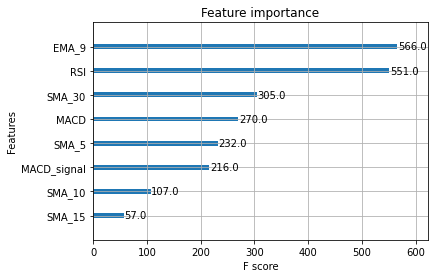

In [23]:
plot_importance(model);


In [24]:
X_train.head()

,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1733.894365,1756.660010,1732.995007,1722.786670,1721.935006,68.955951,13.610950,6.560433
1,1739.902023,1766.620019,1742.220007,1728.436670,1726.173340,63.713077,15.419024,8.545272
2,1744.778892,1776.080005,1751.175000,1734.020003,1729.796671,69.230764,16.050445,10.187361
3,1748.320798,1785.300000,1758.865002,1737.383341,1732.683337,75.437139,14.849183,11.188525
4,1749.451650,1781.140014,1763.935010,1741.083341,1735.545003,60.815961,12.032130,11.367061


In [25]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [1594.099976 1596.449951 1606.25     1582.949951 1597.099976]
y_pred = [1654.1986 1660.2128 1660.2128 1660.2128 1660.2128]


In [26]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


mean_squared_error = 3293.52011901


In [27]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [28]:
X_test.head()

,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
184,1542.197150,1600.900000,1563.730005,1543.103345,1506.976668,64.539813,36.106816,25.205767
185,1549.972430,1611.669995,1578.619995,1550.080005,1512.200000,64.701919,35.188476,27.202309
186,1554.385184,1610.509985,1586.289990,1554.160002,1516.606665,65.565790,34.255432,28.612934
187,1558.591661,1606.469971,1590.964990,1560.169995,1520.508329,80.340345,33.915810,29.673509
188,1563.357495,1603.839966,1596.484985,1567.013330,1524.449996,71.602277,31.404527,30.019713
